# TCN–LGBM Ensemble ETH/USDT

## 1. Inisialisasi & Konfigurasi

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ccxt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from tensorflow import keras
from tensorflow.keras import layers
import joblib
from sklearn.preprocessing import StandardScaler


plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True

class CONFIG:
    symbol = "ETH/USDT"
    timeframe = "1h"
    start = "2020-01-01"
    end = None
    seq_len = 64
    horizon = 1          # 1-step ahead per candle
    train_ratio = 0.7
    val_ratio = 0.15
    tcn_epochs = 50
    tcn_batch = 32


## 2. Pengambilan Data OHLCV

In [55]:
def fetch_ohlcv_ccxt(symbol, timeframe, start=None, end=None, limit=1000):
    ex = ccxt.binance()
    since = ex.parse8601(start + "T00:00:00Z") if start else None
    end_ts = ex.parse8601(end + "T00:00:00Z") if end else None

    all_rows = []
    while True:
        batch = ex.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not batch:
            break

        all_rows.extend(batch)
        last_ts = batch[-1][0]

        # update since untuk next loop
        since = last_ts + 1

        # kalau pakai end, berhenti kalau sudah lewat
        if end_ts is not None and last_ts >= end_ts:
            break

        # kalau batch kurang dari limit, artinya sudah mentok data
        if len(batch) < limit:
            break

    df = pd.DataFrame(all_rows, columns=["timestamp","open","high","low","close","volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df = df.set_index("timestamp").sort_index()
    return df


In [56]:
df = fetch_ohlcv_ccxt(CONFIG.symbol, CONFIG.timeframe, CONFIG.start, CONFIG.end)
print(df.head())
print(df.tail())
print("Total rows:", len(df))


                       open    high     low   close       volume
timestamp                                                       
2020-01-01 00:00:00  129.16  129.19  128.68  128.87   7769.17336
2020-01-01 01:00:00  128.87  130.65  128.78  130.64  11344.65516
2020-01-01 02:00:00  130.63  130.98  130.35  130.85   7603.35623
2020-01-01 03:00:00  130.85  130.89  129.94  130.20   4968.55433
2020-01-01 04:00:00  130.21  130.74  130.15  130.20   3397.90747
                        open     high      low    close      volume
timestamp                                                          
2025-11-13 10:00:00  3486.43  3516.59  3486.43  3506.01  16398.5397
2025-11-13 11:00:00  3506.02  3518.26  3495.41  3501.95  15264.4992
2025-11-13 12:00:00  3501.94  3511.31  3481.42  3501.15  25589.5989
2025-11-13 13:00:00  3501.14  3501.99  3426.43  3438.18  45077.3310
2025-11-13 14:00:00  3438.18  3443.96  3393.55  3427.33  41830.9047
Total rows: 51415


## 3. Pembentukan Fitur & Dataset Supervised

In [ ]:
def make_supervised_tabular(df, seq_len, horizon):
    data = df.copy()
    data["return"] = data["close"].pct_change() # menghitung return (persentase perubahan harga)
    data = data.dropna()

    X_list, y_list, idx_list = [], [], []

    values = data[["open","high","low","close","volume","return"]].values
    closes = data["close"].values
    index = data.index

    for i in range(seq_len, len(data) - horizon + 1):
        X_list.append(values[i-seq_len:i, :].reshape(-1))
        y_list.append(closes[i + horizon - 1])
        idx_list.append(index[i + horizon - 1])

    return np.array(X_list), np.array(y_list), np.array(idx_list)


def make_supervised_sequence(df, seq_len, horizon):
    data = df.copy()
    data["return"] = data["close"].pct_change() # menghitung return (persentase perubahan harga)
    data = data.dropna()

    # Target: tetap pakai CLOSE asli (tidak dinormalisasi)
    closes = data["close"].values
    index = data.index

    # Fitur yang dinormalisasi untuk TCN
    feat_cols = ["open", "high", "low", "close", "volume", "return"]
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(data[feat_cols])

    X_list, y_list, idx_list = [], [], []

    for i in range(seq_len, len(data) - horizon + 1):
        # pakai fitur yang sudah di-scale sebagai input TCN
        X_list.append(feats_scaled[i-seq_len:i, :])
        # tapi y tetap harga close asli
        y_list.append(closes[i + horizon - 1])
        idx_list.append(index[i + horizon - 1])

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    idx = np.array(idx_list)

    return X, y, idx



## 4. Pembagian Data Train / Validasi / Test

In [ ]:
def chronological_data(N, train_ratio=0.7, val_ratio=0.15):
    n_train = int(N * train_ratio)
    n_val = int(N * val_ratio)
    tr_idx = np.arange(0, n_train)
    va_idx = np.arange(n_train, n_train + n_val)
    te_idx = np.arange(n_train + n_val, N)
    return tr_idx, va_idx, te_idx

X_tab, y_tab, idx_all = make_supervised_tabular(df, CONFIG.seq_len, CONFIG.horizon)
X_seq, y_seq, idx_seq = make_supervised_sequence(df, CONFIG.seq_len, CONFIG.horizon)

assert len(X_tab) == len(X_seq) == len(y_tab) == len(y_seq)

N = len(y_tab)
print("Total samples supervised:", N)

tr_idx, va_idx, te_idx = chronological_data(N, CONFIG.train_ratio, CONFIG.val_ratio)
print("Train:", len(tr_idx), "Val:", len(va_idx), "Test:", len(te_idx))

Xtr_tab, Xva_tab, Xte_tab = X_tab[tr_idx], X_tab[va_idx], X_tab[te_idx]
ytr,      yva,      yte   = y_tab[tr_idx], y_tab[va_idx], y_tab[te_idx]

Xtr_seq, Xva_seq, Xte_seq = X_seq[tr_idx], X_seq[va_idx], X_seq[te_idx]
idx_test = idx_all[te_idx]


Total samples supervised: 51350
Train: 35945 Val: 7702 Test: 7703


## 5. Pelatihan Model Dasar LightGBM

In [59]:
def fit_lgbm(Xtr, ytr, Xva, yva):
    train_data = lgb.Dataset(Xtr, label=ytr)
    valid_data = lgb.Dataset(Xva, label=yva, reference=train_data)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.05,
        "num_leaves": 63,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.9,
        "bagging_freq": 5,
        "verbosity": -1,
        "seed": 42,
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, valid_data],
        valid_names=["train","valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    return model


model_lgb_A = fit_lgbm(Xtr_tab, ytr, Xva_tab, yva)


Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 17.4077	valid's rmse: 26.253
[200]	train's rmse: 13.03	valid's rmse: 24.9063
Early stopping, best iteration is:
[170]	train's rmse: 13.6917	valid's rmse: 24.8934


## 6. Perancangan & Pelatihan Model TCN

In [60]:
def build_tcn(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    num_filters = 32
    kernel_size = 3
    dilations = [1, 2, 4, 8]

    for d in dilations:
        conv = layers.Conv1D(
            filters=num_filters,
            kernel_size=kernel_size,
            dilation_rate=d,
            padding="causal",
            activation="relu"
        )(x)
        conv = layers.Dropout(0.1)(conv)
        res = layers.Conv1D(num_filters, 1, padding="same")(x)
        x = layers.Add()([conv, res])
        x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

input_shape = (CONFIG.seq_len, Xtr_seq.shape[-1])
model_tcn_A = build_tcn(input_shape)
model_tcn_A.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 64, 32)    │        608 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64, 32)    │          0 │ conv1d_32[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 64, 32)    │        224 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 64, 32)    │          0 │ dropout_16[0][0], │
│                     │                   │            │ conv1d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 64, 32)    │          0 │ add_16[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 64, 32)    │      3,104 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64, 32)    │          0 │ conv1d_34[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 64, 32)    │      1,056 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 64, 32)    │          0 │ dropout_17[0][0], │
│                     │                   │            │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, 32)    │          0 │ add_17[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 64, 32)    │      3,104 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64, 32)    │          0 │ conv1d_36[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 64, 32)    │      1,056 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 64, 32)    │          0 │ dropout_18[0][0], │
│                     │                   │            │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 64, 32)    │          0 │ add_18[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 64, 32)    │      3,104 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64, 32)    │          0 │ conv1d_38[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 64, 32)    │      1,056 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 15,489 (60.50 KB)

 Trainable params: 15,489 (60.50 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model_tcn_A.fit(
    Xtr_seq, ytr,
    validation_data=(Xva_seq, yva),
    epochs=CONFIG.tcn_epochs,
    batch_size=CONFIG.tcn_batch,
    verbose=1,
    callbacks=[es]
)


Epoch 1/50


2025-11-13 21:51:23.396004: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 55211520 exceeds 10% of free system memory.


1124/1124 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 262692.2500 - val_loss: 7179.7495
Epoch 2/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 5658.5347 - val_loss: 5845.4863
Epoch 3/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 4399.4185 - val_loss: 19260.6582
Epoch 4/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 3659.8022 - val_loss: 28276.6797
Epoch 5/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2968.4253 - val_loss: 16937.1602
Epoch 6/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2248.8499 - val_loss: 11474.4521
Epoch 7/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2356.4456 - val_loss: 1538.6249
Epoch 8/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2048.8779 - val_loss: 3142.9319
Epoch 9/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1694.5508 - val_loss: 1608.8308
Epoch 10/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1677.0714 - val_loss: 10525.7939
Epoch 11/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss:

## 7. Pembentukan Ensemble TCN–LGBM

In [62]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pva_lgb_A = model_lgb_A.predict(Xva_tab)
pte_lgb_A = model_lgb_A.predict(Xte_tab)

pva_tcn_A = model_tcn_A.predict(Xva_seq).reshape(-1)
pte_tcn_A = model_tcn_A.predict(Xte_seq).reshape(-1)

pva_mean_A = 0.5 * (pva_lgb_A + pva_tcn_A)
pte_mean_A = 0.5 * (pte_lgb_A + pte_tcn_A)

rmse_lgb_va = rmse(yva, pva_lgb_A)
rmse_tcn_va = rmse(yva, pva_tcn_A)
w_lgb = 1 / rmse_lgb_va
w_tcn = 1 / rmse_tcn_va
w_sum = w_lgb + w_tcn
w_lgb /= w_sum
w_tcn /= w_sum

pva_wmean_A = w_lgb * pva_lgb_A + w_tcn * pva_tcn_A
pte_wmean_A = w_lgb * pte_lgb_A + w_tcn * pte_tcn_A

Xva_meta = np.column_stack([pva_lgb_A, pva_tcn_A])
Xte_meta = np.column_stack([pte_lgb_A, pte_tcn_A])

meta_A = LinearRegression()
meta_A.fit(Xva_meta, yva)

pva_stack_A = meta_A.predict(Xva_meta)
pte_stack_A = meta_A.predict(Xte_meta)


241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## 8. Evaluasi Kinerja Model

               RMSE         MSE        MAE      MAPE
LGBM      27.841146  775.129392  18.539633  0.594016
TCN       30.041124  902.469132  20.293721  0.679023
Mean      26.768650  716.560616  17.718741  0.582423
W-Mean    26.714763  713.678546  17.672177  0.580148
Stacking  26.473149  700.827629  17.458592  0.568624


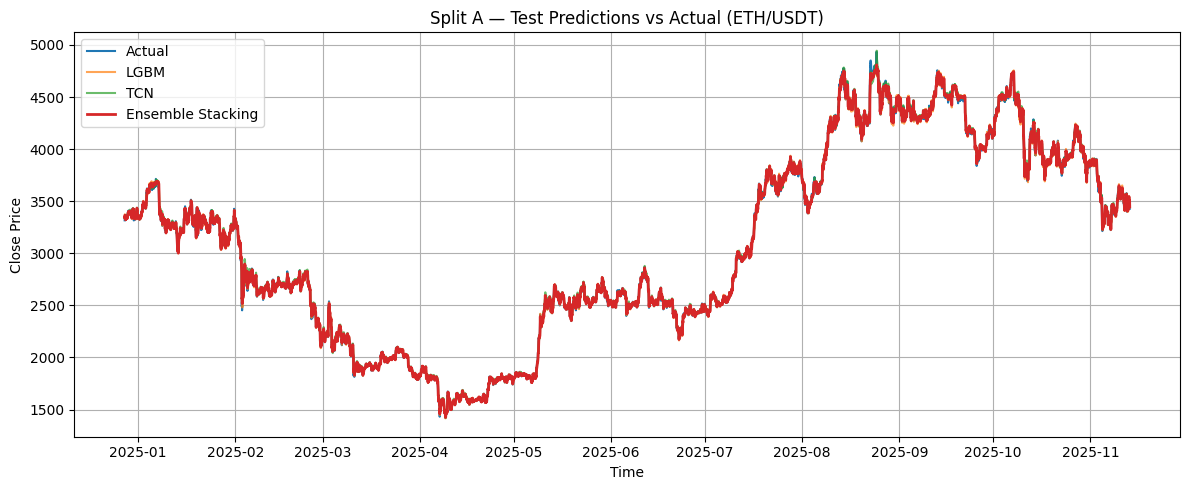

In [63]:
def collect_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
    }

results = {
    "LGBM":      collect_metrics(yte, pte_lgb_A),
    "TCN":       collect_metrics(yte, pte_tcn_A),
    "Mean":      collect_metrics(yte, pte_mean_A),
    "W-Mean":    collect_metrics(yte, pte_wmean_A),
    "Stacking":  collect_metrics(yte, pte_stack_A),
}

metrics_df = pd.DataFrame(results).T
print(metrics_df)

plt.figure()
plt.plot(idx_test, yte, label="Actual")
plt.plot(idx_test, pte_lgb_A, label="LGBM", alpha=0.7)
plt.plot(idx_test, pte_tcn_A, label="TCN", alpha=0.7)
plt.plot(idx_test, pte_stack_A, label="Ensemble Stacking", linewidth=2)
plt.title(f"Split A — Test Predictions vs Actual ({CONFIG.symbol})")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


## 9. Perancangan Fungsi Forecasting Multi-Step & Multi-Horizon

In [64]:
def get_candle_hours(tf: str) -> float:
    tf = tf.strip().lower()
    if tf.endswith("h"):
        return float(tf[:-1])
    if tf.endswith("m"):
        return float(tf[:-1]) / 60.0
    if tf.endswith("d"):
        return float(tf[:-1]) * 24.0
    raise ValueError(f"Timeframe tidak dikenali: {tf}")

def forecast_next_step(df_input, seq_len, model_lgb, model_tcn, meta_model):
    X_tab_all, _, _ = make_supervised_tabular(df_input, seq_len, horizon=1)
    X_seq_all, _, _ = make_supervised_sequence(df_input, seq_len, horizon=1)

    X_tab_last = X_tab_all[-1:]
    X_seq_last = X_seq_all[-1:]

    y_lgb = model_lgb.predict(X_tab_last)
    y_tcn = model_tcn.predict(X_seq_last).reshape(-1)
    X_meta = np.column_stack([y_lgb, y_tcn])
    y_stack = meta_model.predict(X_meta)

    return {
        "pred_lgbm": float(y_lgb[0]),
        "pred_tcn": float(y_tcn[0]),
        "pred_stack": float(y_stack[0]),
    }

def forecast_multi_steps(df_input, steps, seq_len, model_lgb, model_tcn, meta_model):
    df_tmp = df_input.copy()
    preds = []
    for _ in range(int(steps)):
        out = forecast_next_step(df_tmp, seq_len, model_lgb, model_tcn, meta_model)
        y_hat = out["pred_stack"]
        preds.append(y_hat)

        next_ts = df_tmp.index[-1] + pd.Timedelta(CONFIG.timeframe)
        last_row = df_tmp.iloc[-1].copy()
        last_row["close"] = y_hat
        df_tmp.loc[next_ts] = last_row
    return preds

def forecast_hours(df_input, hours_list, seq_len, model_lgb, model_tcn, meta_model):
    tf_h = get_candle_hours(CONFIG.timeframe)
    results = {}
    for h in hours_list:
        raw_steps = h / tf_h
        steps = max(1, int(round(raw_steps)))
        preds = forecast_multi_steps(df_input, steps, seq_len, model_lgb, model_tcn, meta_model)
        results[f"{h}h"] = {
            "steps_used": steps,
            "pred_stack": float(preds[-1]),
        }
    return results


In [65]:
hours_forecast = [1, 5, 30]
forecast_results = forecast_hours(
    df,
    hours_forecast,
    CONFIG.seq_len,
    model_lgb_A,
    model_tcn_A,
    meta_A
)
forecast_results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

{'1h': {'steps_used': 1, 'pred_stack': 3444.9392522960275},
 '5h': {'steps_used': 5, 'pred_stack': 3446.0211819255987},
 '30h': {'steps_used': 30, 'pred_stack': 3443.933628518075}}

## 10. Penyimpanan Model untuk Deployment

In [66]:
# Simpan model untuk deployment
joblib.dump(meta_A, "meta_stack_splitA.pkl")
model_tcn_A.save("tcn_splitA.h5")
# LightGBM Booster
if hasattr(model_lgb_A, "save_model"):
    model_lgb_A.save_model("lgb_splitA.txt")
else:
    model_lgb_A.booster_.save_model("lgb_splitA.txt")

print("Model tersimpan: lgb_splitA.txt, tcn_splitA.h5, meta_stack_splitA.pkl")


Model tersimpan: lgb_splitA.txt, tcn_splitA.h5, meta_stack_splitA.pkl
